In [2]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils import (
    gradient_penalty,
    plot_to_tensorboard,
    save_checkpoint,
    load_checkpoint,
    generate_examples,
    seed_everything
)
from model import Discriminator, Generator
from math import log2
from tqdm import tqdm
import config
import os
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
import random
from skimage.util import random_noise


np.random.seed(4912)
torch.manual_seed(4912)
random.seed(4912)

/home/kworapob/miniconda3/envs/pytorch_py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_transition_codes(num_codes, latent_dim, num_steps=10,device='cuda'):

    start_codes = torch.randn(num_codes, latent_dim,device=device)

    end_codes = torch.randn(num_codes, latent_dim,device=device)
    transition_codes = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)  
        intermediate_codes = (1 - alpha) * start_codes + alpha * end_codes
        transition_codes.append(intermediate_codes)

    return torch.cat(transition_codes)

def show_tensor_test_img(img_tensor,num_imgs=25,nrow=5,size=(5,5),epoch=0):
    img_tensor=(img_tensor+1)/2
    img_unflat = img_tensor.detach().cpu()
    img_unflat = img_unflat.expand(-1, 3, -1, -1)
    img_grid = make_grid(img_unflat[:num_imgs],nrow=nrow)
    plt.figure(figsize=size)
    plt.imshow(img_grid.permute(1,2,0).squeeze())
    plt.axis('off')
    plt.show()

def generate_gif(img_ls, save_path):
    img_ls=(img_ls+1)/2
    img_ls=img_ls.detach().cpu()
    img_ls=img_ls.expand(-1, 3, -1, -1)
    transform = transforms.ToPILImage()
    images = [transform(img) for img in img_ls]
    
    # Save the images as a GIF
    images[0].save(save_path, save_all=True, append_images=images[1:], optimize=False, duration=1, loop=0)

    return images

In [3]:
gen = Generator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)
critic = Discriminator(
        config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG
    ).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(
    gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))
scaler_critic = torch.cuda.amp.GradScaler()
scaler_gen = torch.cuda.amp.GradScaler()
print(gen)
print(critic)

Generator(
  (label_emb): Embedding(11, 10)
  (initial): Sequential(
    (0): PixelNorm()
    (1): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(1, 1))
    (2): LeakyReLU(negative_slope=0.2)
    (3): WSConv2d(
      (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (4): LeakyReLU(negative_slope=0.2)
    (5): PixelNorm()
  )
  (initial_rgb): WSConv2d(
    (conv): Conv2d(512, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (prog_blocks): ModuleList(
    (0-2): 3 x ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv2): WSConv2d(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (leaky): LeakyReLU(negative_slope=0.2)
      (pn): PixelNorm()
    )
    (3): ConvBlock(
      (conv1): WSConv2d(
        (conv): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [4]:
load_checkpoint(
            '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/checkpoint_cleaned-data-secondtry/generator_sz32/generator99_3_1500.pth', gen, opt_gen, config.LEARNING_RATE,
        )

=> Loading checkpoint from /home/kworapob/DIP_AI-Hack_datagen/ProGAN/checkpoint_cleaned-data-secondtry/generator_sz32/generator99_3_1500.pth


[1500, 99, 1]

torch.Size([100, 502, 1, 1])
torch.Size([100])
torch.Size([100, 3, 32, 32])


/home/kworapob/miniconda3/envs/pytorch_py3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv_transpose2d(


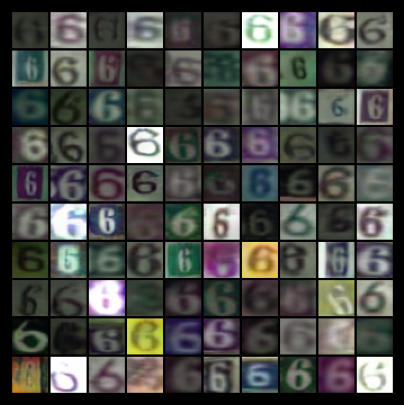

In [5]:
device = "cuda"
step = int(log2(32/ 4))
batch_size = 100
cls_name = 6
noise = torch.randn(batch_size, 502, 1, 1).to(device)
print(noise.shape)
# img_cls = torch.tensor([0,1,2,3,4,5,6,7,8,9]).to(device)
img_cls = torch.tensor([cls_name]*batch_size).to(device)
print(img_cls.shape)
img = gen(noise,img_cls, 1.0, step)
print(img.shape)
show_tensor_test_img(img,num_imgs=100,nrow=10)

In [6]:
def save_generated_images(device="cuda", image_size=32, noise_dim=502, batch_size=100, cls_name=0, gen=None, output_dir="generated_images"):
    step = int(log2(image_size / 4))
    
    noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
    
    img_cls = torch.tensor([cls_name] * batch_size).to(device)
    
    img = gen(noise, img_cls, 1.0, step)
    
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(batch_size):

        img_np = img[i].cpu().detach().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        img_np = (img_np * 255).astype(np.uint8)

        if img_np.shape[0] == 3:
            img_np = np.transpose(img_np, (1, 2, 0))
    
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

        cv2.imwrite(os.path.join(output_dir, f'image{cls_name}_{i+1}.png'), img_np)

    print(f"{batch_size} images saved to {output_dir}")


In [7]:
# For train
np.random.seed(841)
torch.manual_seed(4912)
for i in range(10):
    batch_size = np.random.randint(400,600)
    save_generated_images(gen=gen,batch_size=batch_size,cls_name=i,output_dir=f"generated_images/{i}")

436 images saved to generated_images/0
471 images saved to generated_images/1
517 images saved to generated_images/2
570 images saved to generated_images/3
513 images saved to generated_images/4
552 images saved to generated_images/5
475 images saved to generated_images/6
435 images saved to generated_images/7
517 images saved to generated_images/8
517 images saved to generated_images/9


In [8]:
# For test
np.random.seed(841)
torch.manual_seed(4912)
for i in range(10):
    batch_size = np.random.randint(100,200)
    save_generated_images(gen=gen,batch_size=batch_size,cls_name=i,output_dir=f"generated_test_images")

136 images saved to generated_test_images
171 images saved to generated_test_images
185 images saved to generated_test_images
186 images saved to generated_test_images
142 images saved to generated_test_images
124 images saved to generated_test_images
175 images saved to generated_test_images
135 images saved to generated_test_images
186 images saved to generated_test_images
165 images saved to generated_test_images


In [3]:
def gaussian_blur(image):
        gauss_kernel_size_pool = [5,7,9,11]
        # gauss_kernel_size_pool = [1,3]
        gauss_kernel_size = random.choice(gauss_kernel_size_pool)
        gauss_blurimage = cv2.GaussianBlur(image, (gauss_kernel_size,gauss_kernel_size), 5)
        # print("gauss_kernel_size :",gauss_kernel_size)
        return gauss_blurimage
    
def padding(image,pad,fill_mode='reflect'):
    return np.pad(image, pad, fill_mode)
    # return F.pad(image, pad, fill_mode)

def center_crop_image(image,size):
    h, w = image.shape[:2]
    new_h, new_w = size
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    image = image[top:top + new_h, left:left + new_w]
    return image

def add_gaussian_noise(image):
    # Add Gaussian noise to the image
    noisy_image = random_noise(image,var=0.02,mean=0, mode='gaussian')

    return noisy_image

def random_aspect_ratio_change(image, aspect_ratio_range=(0.5, 1.5)):
    original_height, original_width = image.shape[:2]
    
    new_aspect_ratio = random.uniform(aspect_ratio_range[0], aspect_ratio_range[1])
    if new_aspect_ratio > 1:
        new_width = int(original_width * new_aspect_ratio)
        new_height = original_height
    else:
        new_height = int(original_height / new_aspect_ratio)
        new_width = original_width
    print('new_width',new_width,"new_height",new_height)
    resized_image = cv2.resize(image, (new_width, new_height))
    
    return resized_image

def rotate(image,angle_range=(-45,45)):
    angle = random.randint(angle_range[0], angle_range[1])
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    M = np.float32(M)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image


def shear(image,shear_range=(-0.5,0.5)):
    shear = random.uniform(shear_range[0], shear_range[1])
    rows, cols, _ = image.shape
    M = np.array([[1, shear, 0], [0, 1, 0]])
    M = np.float32(M)
    image = cv2.warpAffine(image, M, (cols, rows))
    return image

def random_gaussian_patches_color(img, n=10, tile_size=10, ksize=3, sigma=1.0):

  output = img.copy()
  height, width = img.shape[:2]
  blurred_patch = np.zeros(img.size)

  for _ in range(n):
    # Randomly select top-left corner of the patch
    x = np.random.randint(0, height - tile_size)
    y = np.random.randint(0, width - tile_size)    
    
    # print(x,y)

    # Extract the patch for each channel
    patch_r = img[x:x+tile_size, y:y+tile_size, 0]
    patch_g = img[x:x+tile_size, y:y+tile_size, 1]
    patch_b = img[x:x+tile_size, y:y+tile_size, 2]
    
    # print(patch_b.shape)
    # print(cv2.GaussianBlur(patch_b, (ksize, ksize), sigma, borderType=cv2.BORDER_REFLECT))
    # print(img[x:x+tile_size, y:y+tile_size,0])
    # Apply Gaussian blur to each channel
    blurred_patch_r = cv2.GaussianBlur(patch_r, (ksize, ksize), sigma, cv2.BORDER_DEFAULT)#borderType=cv2.BORDER_REFLECT)
    blurred_patch_g = cv2.GaussianBlur(patch_g, (ksize, ksize), sigma, cv2.BORDER_DEFAULT)#borderType=cv2.BORDER_REFLECT)
    blurred_patch_b = cv2.GaussianBlur(patch_b, (ksize, ksize), sigma, cv2.BORDER_DEFAULT)#borderType=cv2.BORDER_REFLECT)

    # Combine blurred channels back into a patch
    output[x:x+tile_size, y:y+tile_size,0] = blurred_patch_r
    output[x:x+tile_size, y:y+tile_size,1] = blurred_patch_g
    output[x:x+tile_size, y:y+tile_size,2] = blurred_patch_b
  return output

def random_salt_pepper_patches_color(img, n=10, tile_size=10):

  output = img.copy()
  height, width = img.shape[:2]
  blurred_patch = np.zeros(img.size)

  for _ in range(n):
    # Randomly select top-left corner of the patch
    x = np.random.randint(0, height - tile_size)
    y = np.random.randint(0, width - tile_size)    
    
    # print(x,y)
    
    patch_r = 255 if np.random.rand() > 0.5 else 0
    # patch_g = 255 if np.random.rand() > 0.5 else 0
    # patch_b = 255 if np.random.rand() > 0.5 else 0
  
    # Combine blurred channels back into a patch
    output[x:x+tile_size, y:y+tile_size,0] = patch_r
    output[x:x+tile_size, y:y+tile_size,1] = patch_r
    output[x:x+tile_size, y:y+tile_size,2] = patch_r

    
    # plt.subplot(1,4,1), plt.imshow(img[x:x+tile_size, y:y+tile_size])
    # plt.subplot(1,4,2), plt.imshow(blurred_patch_r,cmap="gray")
    # plt.subplot(1,4,3), plt.imshow(blurred_patch_g,cmap="gray")
    # plt.subplot(1,4,4), plt.imshow(blurred_patch_b,cmap="gray")
  return output

def resize_img(image, min_scale=0.5, max_scale=1.2):
    scale_factor = random.uniform(min_scale, max_scale)
    resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)

    return resized_image

def gamma(image):
    gamma_val = np.random.uniform(0.2, 1.5)  # Generate random gamma value between 0 and 2
    image = np.power(image / 255.0, gamma_val) * 255.0  # Apply gamma correction
    return image.astype(np.uint8)  # Ensure output is in uint8 format


def magic_number(prob=0.5):
    random_value = random.random()
    return random_value < prob

def image_pipeline(image):
    do_nothing = magic_number(prob=0.3)
    if not do_nothing:
        # TEST SET
        # apply_gaussian_blur = magic_number(prob=0.4)
        # apply_padding = magic_number(prob=0)
        # apply_center_crop = magic_number(prob=0.5)
        # apply_gaussian_noise = magic_number(prob=0)
        # apply_aspect_ratio_change = magic_number(prob=0.4)
        # apply_rotate = magic_number(prob=0.3)
        # apply_shear = magic_number(prob=0.2)
        # apply_gaussian_patches = magic_number(prob=0)
        # apply_salt_pepper_patches = magic_number(prob=0)
        # apply_resize = magic_number(prob=0.1)
        # apply_gamma = magic_number(prob=0)

        # apply_gaussian_blur = magic_number(prob=0)
        # apply_padding = magic_number(prob=0.5)
        # apply_center_crop = magic_number(prob=0)
        # apply_gaussian_noise = magic_number(prob=0.3)
        # apply_aspect_ratio_change = magic_number(prob=0.4)
        # apply_rotate = magic_number(prob=0)
        # apply_shear = magic_number(prob=0.2)
        # apply_gaussian_patches = magic_number(prob=0)
        # apply_salt_pepper_patches = magic_number(prob=0)
        # apply_resize = magic_number(prob=0.5)
        # apply_gamma = magic_number(prob=0.5)

        apply_gaussian_blur = magic_number(prob=0)
        apply_padding = magic_number(prob=0.5)
        apply_center_crop = magic_number(prob=0)
        apply_gaussian_noise = magic_number(prob=0.1)
        apply_aspect_ratio_change = magic_number(prob=0.8)
        apply_rotate = magic_number(prob=0)
        apply_shear = magic_number(prob=0.2)
        apply_gaussian_patches = magic_number(prob=0)
        apply_salt_pepper_patches = magic_number(prob=0)
        apply_resize = magic_number(prob=0.5)
        apply_gamma = magic_number(prob=0.5)

        # TRAIN SET
        # apply_gaussian_blur = magic_number(prob=0)
        # apply_padding = magic_number(prob=0.5)
        # apply_center_crop = magic_number(prob=0)
        # apply_gaussian_noise = magic_number(prob=0)
        # apply_aspect_ratio_change = magic_number(prob=0.6)
        # apply_rotate = magic_number(prob=0)
        # apply_shear = magic_number(prob=0)
        # apply_gaussian_patches = magic_number(prob=0)
        # apply_salt_pepper_patches = magic_number(prob=0)
        # apply_resize = magic_number(prob=0.5)
        # apply_gamma = magic_number(prob=0)


        if apply_gamma:
            image = gamma(image)
            print("gamma Applied", image.shape,image.dtype,image.min(),image.max())
        if apply_resize:
            image = resize_img(image)
            print("resize Applied", image.shape,image.dtype,image.min(),image.max())
        if apply_gaussian_blur:
            image = gaussian_blur(image)
            print("Gaussian Blur Applied:", image.shape,image.dtype,image.min(),image.max())
        if apply_padding:
            # image = padding(image, pad=((224,224),(224,224),(0,0)), fill_mode='reflect')
            if magic_number(prob=0.5):
                image = padding(image, pad=((0,0),(int(image.shape[0]*0.5),int(image.shape[0]*0.5)),(0,0)), fill_mode='edge')
            else:
                image = padding(image, pad=((int(image.shape[0]*0.5),int(image.shape[0]*0.5)),(0,0),(0,0)), fill_mode='edge')
            print("Padding Applied:", image.shape,image.dtype,image.min(),image.max())
        if apply_gaussian_noise:
            image = add_gaussian_noise(image)
            image = (image - image.min()) / (image.max() - image.min()) * 255
            print("Gaussian Noise Applied:", image.shape,image.dtype,image.min(),image.max())
        if apply_aspect_ratio_change:
            image = random_aspect_ratio_change(image)
            print("Aspect Ratio Change Applied:", image.shape,image.dtype,image.min(),image.max())
        # if apply_center_crop:
        #     image = center_crop_image(image, size=(224, 224))
        #     print("Center Crop Applied:", image.shape)
        if apply_gaussian_patches:
            try:
                image = random_gaussian_patches_color(image,tile_size=int(image.shape[0]*0.2),ksize=9,sigma=9)
                print("Gaussian Patches Applied:", image.shape,image.dtype,image.min(),image.max())    
            except (ValueError, TypeError) as e:
                pass
        if apply_salt_pepper_patches:
            try :
                image = random_salt_pepper_patches_color(image,tile_size=int(image.shape[0]*0.05))
                print("Salt & Pepper Patches Applied:", image.shape,image.dtype,image.min(),image.max())
            except (ValueError, TypeError) as e:
                pass
        if apply_rotate:
            image = rotate(image,(-5,5))
            print("Rotation Applied:", image.shape,image.dtype,image.min(),image.max())
        if apply_shear:
            image = shear(image,(-0.1,0.1))
            print("Shear Applied:", image.shape,image.dtype,image.min(),image.max())
        

    return image

def iterate_all_image(image_paths):
    for image_path in image_paths:
        print('----------------')
        print(image_path)
        image = cv2.imread(image_path)
        print('image.shape',image.shape)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image_pipeline(image)
        print('out image.shape',image.shape,image.dtype)
        if image.min() == 0.0 and image.max()==1.0:
            image *= 255
        image = image.astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_path,image)
        
def get_file_paths(dataset_dir):
    subdirs = [os.path.join(dataset_dir, d) for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    file_paths = []
    for subdir in subdirs:
        file_paths.extend(glob(os.path.join(subdir, '*')))

    return file_paths

In [10]:
root = '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images'
image_paths = get_file_paths(root)
print(image_paths)
iterate_all_image(image_paths)

['/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_236.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_279.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_148.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_372.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_228.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_40.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_301.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_434.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_379.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_49.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_242.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_images/7/image7_91.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_i

In [4]:
root = '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images'
image_paths = get_file_paths(root)
print(image_paths)
iterate_all_image(image_paths)

['/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image5_18.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image0_44.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image8_38.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image5_86.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image0_67.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image6_141.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image8_74.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image0_123.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image6_7.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image9_17.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data/image2_117.png', '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generate

In [5]:
import os
import csv
import random

def rename_images_and_create_csv(image_dir, output_csv):
    image_mappings = []
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    random.shuffle(image_files)
    for i, old_name in enumerate(image_files):

        new_name = f'image_{i:04d}.png'
        

        old_path = os.path.join(image_dir, old_name)
        new_path = os.path.join(image_dir, new_name)
        

        os.rename(old_path, new_path)
        

        class_label = int(old_name.split('_')[0].replace('image', ''))
        

        image_mappings.append([new_name, class_label])
    
    with open(output_csv, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image_name', 'class_label'])
        writer.writerows(image_mappings)


image_dir = '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/generated_test_images/data'
output_csv = '/home/kworapob/DIP_AI-Hack_datagen/ProGAN/testset_class_mapping.csv'

rename_images_and_create_csv(image_dir, output_csv)
